<a href="https://colab.research.google.com/github/Jswirls/NFL_pbp_sim/blob/main/NFL_pbp_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
pip install nfl_data_py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Imports

In [340]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [341]:
seasons = [2018,2019,2020]
pbp = nfl.import_pbp_data([2020])
rosters = nfl.import_depth_charts(seasons)
weekly_2020 = nfl.import_weekly_data([2020],columns=['week','season','player_id','recent_team','completions','attempts','passing_yards','passing_tds','sacks','carries',
                                                    'rushing_yards','rushing_tds','interceptions','sack_fumbles','rushing_fumbles','receptions','targets','receiving_tds',
                                                    'receiving_yards','receiving_fumbles'])
pbp_cols = ['game_id','home_team','away_team','season_type','week','posteam_type','yardline_100','game_date','half_seconds_remaining','game_seconds_remaining','down','goal_to_go',
            'ydstogo','play_type','yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel','qb_spike','qb_scramble','pass_length','pass_location','air_yards','yards_after_catch',
            'run_location','run_gap','field_goal_result','kick_distance','extra_point_result','two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining',
            'timeout','td_player_id','total_home_score','total_away_score','punt_blocked','incomplete_pass','interception','touchback','punt_fair_catch','fumble_forced','fumble_not_forced','rushing_yards',
            'safety','penalty','fumble_lost','qb_hit','sack','touchdown','return_touchdown','extra_point_attempt','two_point_attempt','field_goal_attempt','punt_attempt','fumble', 'wp',
            'passer_player_id','receiver_player_id','rusher_player_id','interception_player_id','punt_returner_player_id','kickoff_returner_player_id','punter_player_id','kicker_player_id',
            'tackle_for_loss_1_player_id','solo_tackle_1_player_id','assist_tackle_1_player_id','pass_defense_1_player_id','tackle_with_assist_1_player_id','fumbled_1_player_id','fumble_recovery_1_player_id',
            'sack_player_id','half_sack_1_player_id','half_sack_2_player_id','penalty_player_id','penalty_type','season','special_teams_play','spread_line','total_line','div_game','home_coach','away_coach', 'score_differential', 'out_of_bounds'
            ]
pbp = pbp[pbp_cols]

2020 done.
Downcasting floats.
Downcasting floats.


#Home/Away Data

In [342]:
teams = weekly_2020.groupby('recent_team')
teams_ha = weekly_2020.groupby('recent_team')
stats = (teams.sum().divide(teams['week'].max(), axis=0))
stats['comp_percentage'] = stats['completions']/stats['attempts']

In [343]:
weekly_matchups = pbp[['home_team','away_team','week']].drop_duplicates()
mid = weekly_2020.merge(weekly_matchups, left_on=['week','recent_team'],right_on=['week','home_team'],how='left')
weekly_2020 = mid.merge(weekly_matchups, left_on=['week','recent_team'],right_on=['week','away_team'],how='left')
weekly_2020['home_team_x'].fillna(weekly_2020['home_team_y'],inplace=True)
weekly_2020['away_team_x'].fillna(weekly_2020['away_team_y'],inplace=True)
weekly_2020.drop(['home_team_y','away_team_y'], axis=1,inplace= True)
weekly_2020.rename({'home_team_x': 'home_team', 'away_team_x' : 'away_team'},axis=1, inplace=True)
weekly_2020['opp'] = weekly_2020['home_team']
weekly_2020.loc[weekly_2020['opp'] == weekly_2020['recent_team'], 'opp'] = weekly_2020['away_team']
home_off = weekly_2020.loc[weekly_2020['home_team'] == weekly_2020['recent_team']]
away_off = weekly_2020.loc[weekly_2020['away_team'] == weekly_2020['recent_team']]
home_def = weekly_2020.loc[weekly_2020['home_team'] == weekly_2020['opp']]
away_def = weekly_2020.loc[weekly_2020['away_team'] == weekly_2020['opp']]

In [344]:
n_home = home_off.drop_duplicates(subset=['week','home_team','away_team'])
team_n_home = n_home.groupby('recent_team')
h_game_counts = (team_n_home.count()['week'])
n_away = away_off.drop_duplicates(subset=['week','home_team','away_team'])
team_n_away = n_away.groupby('recent_team')
a_game_counts = (team_n_away.count()['week'])

In [345]:
#gets average of home and away games for all teams, used to adjust true team stats
h_group = home_off.groupby('recent_team')
a_group = away_off.groupby('recent_team')
h_averages = h_group.sum().divide(h_game_counts, axis=0)
a_averages = a_group.sum().divide(a_game_counts, axis=0)
h_avg = h_averages.mean()
a_avg = a_averages.mean()
adj_h = h_averages + (h_averages - h_avg)
adj_a = a_averages + (a_averages - a_avg)
adj_h = adj_h.drop(['week'],axis=1)
adj_a = adj_a.drop(['week'],axis=1)
h_avg = h_avg.drop(['week'])
a_avg = a_avg.drop(['week']) 
adj_offs = (adj_a + adj_h)/2
adj_offs['YPC'] = adj_offs['rushing_yards']/adj_offs['carries']
adj_offs['YPA'] = adj_offs['passing_yards']/adj_offs['attempts']
adj_offs['sack_rate'] = adj_offs['sacks']/(adj_offs['attempts']+adj_offs['sacks'])
adj_offs['int_rate'] = adj_offs['interceptions']/(adj_offs['attempts'])
adj_offs['sack_fumble_rate'] = adj_offs['sack_fumbles']/(adj_offs['sacks'])
adj_offs['rushing_fumble_rate'] = adj_offs['rushing_fumbles']/(adj_offs['carries'])
adj_offs['receiving_fumble_rate'] = adj_offs['receiving_fumbles']/(adj_offs['receptions'])
adj_offs.loc[adj_offs['sack_fumble_rate'] < .005, 'sack_fumble_rate'] = .005
adj_offs.loc[adj_offs['rushing_fumble_rate'] < .005, 'rushing_fumble_rate'] = .005
adj_offs.loc[adj_offs['receiving_fumble_rate'] < .005, 'receiving_fumble_rate'] = .005

In [346]:
#gets average of home and away games for all teams, used to adjust true team stats
h_group = home_off.groupby('opp')
a_group = away_off.groupby('opp')
h_averages = h_group.sum().divide(h_game_counts, axis=0)
a_averages = a_group.sum().divide(a_game_counts, axis=0)
h_avg = h_averages.mean()
a_avg = a_averages.mean()
adj_h = h_averages + (h_averages - h_avg)
adj_a = a_averages + (a_averages - a_avg)
adj_h = adj_h.drop(['week'],axis=1)
adj_a = adj_a.drop(['week'],axis=1)
h_avg = h_avg.drop(['week'])
a_avg = a_avg.drop(['week']) 
adj_defs = (adj_a + adj_h)/2
adj_defs['YPC'] = adj_defs['rushing_yards']/adj_defs['carries']
adj_defs['YPA'] = adj_defs['passing_yards']/adj_defs['attempts']
adj_defs['sack_rate'] = adj_defs['sacks']/(adj_defs['attempts']+adj_defs['sacks'])
adj_defs['int_rate'] = adj_defs['interceptions']/(adj_defs['attempts'])
adj_defs['sack_fumble_rate'] = adj_defs['sack_fumbles']/(adj_defs['sacks'])
adj_defs['rushing_fumble_rate'] = adj_defs['rushing_fumbles']/(adj_defs['carries'])
adj_defs['receiving_fumble_rate'] = adj_defs['receiving_fumbles']/(adj_defs['receptions'])
adj_defs.loc[adj_defs['sack_fumble_rate'] < .005, 'sack_fumble_rate'] = .005
adj_defs.loc[adj_defs['rushing_fumble_rate'] < .005, 'rushing_fumble_rate'] = .005
adj_defs.loc[adj_defs['receiving_fumble_rate'] < .005, 'receiving_fumble_rate'] = .005

Very advantage across most stats for the home team, slightly more yards, tds etc. Sacks being negative is good for team, as sacks here are sacks taken by the team and not sacks the team got on the opponent.

#PBP grouping

In [347]:
pbp = pbp.loc[pbp['penalty_type'].isna()]
pbp.loc[pbp['air_yards'] < 5, 'pass_length'] = 'short'
pbp.loc[(pbp['air_yards'] > 5) & (pbp['air_yards'] <= 15), 'pass_length'] = 'medium'
pbp.loc[pbp['air_yards'] > 15, 'pass_length'] = 'deep'
pbp.loc[((pbp['yardline_100'] <= 20) & (pbp['yardline_100'] > pbp['air_yards'])), 'pass_length'] = 'rz_short'
pbp.loc[((pbp['yardline_100'] <= 20) & (pbp['yardline_100'] <= pbp['air_yards'])), 'pass_length'] = 'rz_endzone'
pbp.loc[((pbp['yardline_100'] > 20) & (pbp['yardline_100'] <= pbp['air_yards'])), 'pass_length'] = 'long_endzone'
pbp.loc[((pbp['passer_player_id'].notna()) & (pbp['receiver_player_id'].isna())), 'pass_length'] = 'throw_away'
pbp.loc[pbp['sack'] == 1, 'pass_length'] = 'sack'
pbp.loc[pbp['qb_scramble'] == 1, 'pass_length'] = 'scramble'
pbp.loc[pbp['qb_scramble'] == 1, 'passer_player_id'] = pbp['rusher_player_id']
pbp.loc[pbp['qb_spike'] == 1, 'pass_length'] = 'spike'
pbp.loc[pbp['qb_kneel'] == 1, 'pass_length'] = 'kneel'
pbp.loc[pbp['qb_scramble'] == 1, 'rusher_player_id'] = None
passing_plays = pbp.loc[pbp['pass_length'].notna()]
non_passing = pbp.loc[pbp['pass_length'].isna()]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [348]:
rec_plays = passing_plays.loc[pbp['receiver_player_id'].notna()]
rec_plays.loc[rec_plays['pass_length'] == 'short', 'pass_length_rec'] = 'rec_short'
rec_plays.loc[rec_plays['pass_length'] == 'medium', 'pass_length_rec'] = 'rec_medium'
rec_plays.loc[rec_plays['pass_length'] == 'deep', 'pass_length_rec'] = 'rec_deep'
rec_plays.loc[rec_plays['pass_length'] == 'rz_short', 'pass_length_rec'] = 'rec_rz_short'
rec_plays.loc[rec_plays['pass_length'] == 'rz_endzone', 'pass_length_rec'] = 'rec_rz_endzone'
rec_plays.loc[rec_plays['pass_length'] == 'long_endzone', 'pass_length_rec'] = 'rec_long_endzone'
running_plays = non_passing.loc[non_passing['run_gap'].notna()]
fg_plays = non_passing.loc[non_passing['play_type'] == 'field_goal']
extra_point_plays = non_passing.loc[non_passing['play_type'] == 'extra_point']
kickoff_plays = non_passing.loc[non_passing['play_type'] == 'kickoff']
punt_plays = non_passing.loc[non_passing['play_type'] == 'punt']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#Rosters

In [349]:
rosters = rosters[['season','week','team','formation','position','depth_team','full_name','gsis_id']]
rosters = rosters.drop(rosters[(((rosters.position != 'K') & (rosters.position !=  'P')) & (rosters.formation == 'Special Teams'))].index)
player_info = rosters[['gsis_id','position','full_name','formation']]
player_info.rename({'gsis_id' : 'player_id'}, inplace=True, axis=1)
player_info.drop_duplicates(inplace=True)
team_rosters_weekly = rosters.groupby(['team','season','week'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


#Pre-Play Decison Data and Models


## Coach Data Creation

In [220]:
pbp['play_category'] = None
pbp.loc[((pbp['down'] == 1) & (pbp['ydstogo'] == 10)),'play_category'] = '1_down'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] < 3)),'play_category'] = '2_short'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] < 3)),'play_category'] = '3/4_short'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] < 3)),'play_category'] = '3/4_short'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '2_medium'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '3/4_medium'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '3/4_medium'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '2_long'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '3/4_long'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '3/4_long'
pbp.loc[pbp['qb_scramble'] == 1, 'play_type'] = 'pass'

In [221]:
coaches = list(pbp['home_coach'].drop_duplicates())
pbp['neutral'] = 0
pbp.loc[(pbp['half_seconds_remaining'] > 180) & ((pbp['wp'] < .9) & (pbp['wp'] > .1)), 'neutral'] = 1
pbp['pos_coach'] = pbp['home_coach']
pbp.loc[(pbp['posteam_type']) == 'away','pos_coach'] = pbp['away_coach']
pass_run_only = pbp[(pbp['play_type'] == 'pass') | (pbp['play_type'] == 'run')]
neutral_plays = pass_run_only.loc[pbp['neutral'] == 1]

In [224]:
#DATA NOT CURRENTLY USED, KEEPING FOR POSSIBLE USE FOR HAND MODEL
losing_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] > 180) & ((pass_run_only['wp'] < .1))]
winning_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] > 180) & ((pass_run_only['wp'] > .9))]
two_minute_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & ((pass_run_only['wp'] < .9) & (pass_run_only['wp'] > .1))]
two_minute_losing_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & (pass_run_only['wp'] < .1)]
two_minute_winning_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & (pass_run_only['wp'] > .9)]

losing = losing_plays[['play_category','play_type']]
winning = winning_plays[['play_category','play_type']]
two_minute = two_minute_plays [['play_category','play_type']]
two_min_winning = two_minute_winning_plays[['play_category','play_type']]
two_min_losing =  two_minute_losing_plays[['play_category','play_type']]

In [229]:
coach_data = neutral_plays[['pos_coach','play_category','play_type']].dropna()
coach_groups = coach_data.groupby(['pos_coach','play_category'])

coach_dict = {}
for i in coaches:
    coach_dict[i] = {'1_down':0,'2_short':0,'3/4_short':0,'2_medium':0,'3/4_medium':0,'2_long':0,'3/4_long':0}

for g in coach_groups.groups:
  if 'pass' in list(coach_groups.get_group(g)['play_type']):
    coach_dict[g[0]][g[1]] = coach_groups.get_group(g)['play_type'].value_counts()['pass']/coach_groups.get_group(g)['play_type'].count()    

coach_df = pd.DataFrame(coach_dict).transpose()
coach_df.loc['DEFAULT'] = coach_df.mean()
coach_dict = coach_df.transpose().to_dict()

In [230]:
categories = ['1_down','2_short','3/4_short','2_medium','3/4_medium','2_long','3/4_long']
for i in coaches:
  for j in categories:
    pass_run_only.loc[(pass_run_only['play_category'] == j) & (pass_run_only['pos_coach'] == i), 'coach_neutral_pass_rate'] = coach_dict[i][j]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##4th Down Decsion

In [308]:
fourth_down_data = pbp.loc[(pbp['down'] == 4)][['play_type','pos_coach','yardline_100','half_seconds_remaining','game_seconds_remaining','goal_to_go','ydstogo','score_differential']]
fourth_down_data.loc[(fourth_down_data['play_type'] == 'pass') | (fourth_down_data['play_type'] == 'run'), 'play_type'] = 'go_for_it'
fourth_down_data.dropna(inplace=True)
fourth_down_data = fourth_down_data.loc[(fourth_down_data['play_type'] != 'qb_kneel') & (fourth_down_data['play_type'] != 'no_play')]
fourth_down_data['play_type'].unique()

In [327]:
coach_fourth_down_data = fourth_down_data[['pos_coach','play_type']]
coach_fourth_down_groups = coach_fourth_down_data.groupby('pos_coach')
coach_fourth_down_dict = {}
for i in coaches:
    coach_fourth_down_dict[i] = {'go_for_it_rate' : 0}

for g in coach_fourth_down_groups.groups:
  if 'go_for_it' in list(coach_fourth_down_groups.get_group(g)['play_type']):
    coach_fourth_down_dict[g]['go_for_it_rate'] = coach_fourth_down_groups.get_group(g)['play_type'].value_counts()['go_for_it']/coach_fourth_down_groups.get_group(g)['play_type'].count()

coach_fourth_down_df = pd.DataFrame(coach_fourth_down_dict).transpose()
coach_fourth_down_df.loc['DEFAULT'] = coach_fourth_down_df.mean()
coach_fourth_down_dict = coach_fourth_down_df.transpose().to_dict()
fourth_down_data = fourth_down_data.merge(coach_fourth_down_df, left_on='pos_coach', right_index=True).drop('pos_coach',axis=1)

In [331]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
num_cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential','go_for_it_rate']
fourth_down_scaler = StandardScaler()
fourth_down_data[num_cols] = fourth_down_scaler.fit_transform(fourth_down_data[num_cols])
X = fourth_down_data.drop('play_type',axis=1)
y = fourth_down_data['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
fourth_down_clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
fourth_down_clf.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9136522753792299

In [334]:
X_test_pred = fourth_down_clf.predict(X_test)

In [337]:
np.unique(X_test_pred,return_counts=True)

(array(['field_goal', 'go_for_it', 'punt'], dtype='<U10'),
 array([246, 158, 453]))

In [338]:
np.unique(y_test,return_counts=True)

(array(['field_goal', 'go_for_it', 'punt'], dtype=object),
 array([239, 172, 446]))

##Pass Run Model


###MLP Model

In [291]:
pred_vars = pass_run_only[['play_type','yardline_100','half_seconds_remaining','game_seconds_remaining','down','goal_to_go','ydstogo','score_differential','neutral','coach_neutral_pass_rate']]
pred_vars['down']=pred_vars.down.astype('category')
dummies = pd.get_dummies(pred_vars['down'])
pred_vars = pd.concat([pred_vars,dummies],axis=1)
pred_vars.drop('down',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [286]:
num_cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential','coach_neutral_pass_rate']
pred_vars.dropna(inplace=True)

pass_run_scaler = StandardScaler()
pred_vars[num_cols] = pass_run_scaler.fit_transform(pred_vars[num_cols])
X = pred_vars.drop('play_type',axis=1)
y = pred_vars['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pass_run_clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
pass_run_clf.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.7203337068858174

In [ ]:
X_test_pred = pass_run_clf.predict(X_test)

In [ ]:
np.unique(X_test_pred,return_counts=True)

In [ ]:
np.unique(y_test,return_counts=True)

###Handmade Model (IN PROGRESS)

In [41]:
import numpy as np

In [121]:
pass_run = pbp.loc[(pbp['play_type'] == 'pass') | (pbp['play_type'] == 'run')]
pass_run = pass_run[['play_type','yardline_100','half_seconds_remaining','game_seconds_remaining','down','goal_to_go','ydstogo','score_differential','neutral','pos_coach','play_category']]

In [155]:
def can_run_out_clock(data):
  if data['posteam_type'] == 'home':
    opp_team_to = 38 * data['away_timeouts_remaining']
  elif data['posteam_type'] == 'away':
    opp_team_to = 38 * data['home_timeouts_remaining']
  return ((4 - data['down']) * 40) - opp_team_to >= data['game_seconds_remaining']

In [131]:
def pass_run_choice(data):
  if data['pos_coach'] in data.index:
    coach = data['pos_coach']
  else:
    coach = 'DEFAULT'
  category = data['play_category']
  if data['neutral'] == 1:
    pred_play = np.random.choice(['pass','run'], 1, p=[coach_df.loc[coach][category], 1 - coach_df.loc[coach][category]])
  return pred_play[0]

#Misc

In [ ]:
class pbp_game_sim:
  def __init__(self, home_team, away_team, year, week, neutral_loc = False):
    self.home_team = team_rosters_weekly.get_group((home_team,year,week))
    self.away_team = team_rosters_weekly.get_group((home_team,year,week))
    self.home_qb = qb_data[home_team.loc[('position'=='QB') & ('depth_team' == 1),'gsis_id']]
    self.away_qb = qb_data[away_team.loc[('position'=='QB') & ('depth_team' == 1),'gsis_id']]
    self.selfhome_wrs = wr_data[list(home_team.loc[('position'=='WR'),'gsis_id'])]
    self.away_wrs = wr_data[list(away_team.loc[('position'=='WR'),'gsis_id'])]
    self.home_rbs = rb_data[list(home_team.loc[('position'=='RB'),'gsis_id'])]
    self.away_rbs = rb_data[list(away_team.loc[('position'=='RB'),'gsis_id'])]
    self.home_tes = te_data[list(home_team.loc[('position'=='TE'),'gsis_id'])]
    self.away_tes = te_data[list(away_team.loc[('position'=='TE'),'gsis_id'])]
    self.home_def = def_data[list(home_team.loc[('position'=='TE'),'gsis_id'])]
    self.away_def = def_data[list(away_team.loc[('position'=='TE'),'gsis_id'])]

#In Play Data and Models

##Individual Player Data


In [22]:
game_id_merge = pbp[['game_id','home_team','away_team','week','season']]
weekly_2020 = weekly_2020.merge(game_id_merge,how='left',on=['home_team','away_team','week','season']).drop_duplicates()
w_2020_games = weekly_2020.groupby('game_id')['targets']

In [23]:
target_share = pd.Series()
carries_share = pd.Series()
w_2020_games = weekly_2020.groupby('game_id')
for game in w_2020_games.groups:
  temp_target_share = w_2020_games.get_group(game)['targets']/w_2020_games.get_group(game)['targets'].sum()
  temp_carries_share = w_2020_games.get_group(game)['carries']/w_2020_games.get_group(game)['carries'].sum()
  target_share = pd.concat([target_share,temp_target_share])
  carries_share = pd.concat([carries_share,temp_carries_share])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [24]:
weekly_2020 = weekly_2020.merge(target_share.rename('target_share'),how='left', left_index=True,right_index=True)
weekly_2020 = weekly_2020.merge(carries_share.rename('carries_share'),how='left', left_index=True,right_index=True)
weekly_2020['comp_per'] = weekly_2020['completions']/weekly_2020['attempts']

##Advanced Player Model/Data (WIP)

In [422]:
class Player:
  def __init__(self, player_id, pos, name):
    self.player_id = player_id
    self.pos = pos
    self.name = name
    self.games_order = []
    self.play_dists = {}
    self.target_share = 0
    self.carries_share = 0
    self.max_air_yards = 0
    self.comp_pers = {}
    
  #Adds play data for passing plays
  def add_pbp_passing_data(self, game, game_id):
    play_data = game.groupby('pass_length')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','air_yards','incomplete_pass','interception','sack','yardline_100','rushing_yards','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
      if current_game[play]['air_yards'].max() > self.max_air_yards:
        self.max_air_yards = current_game[play]['air_yards'].max()
    self.games_order.append(game_id)

  #Adds play data for rushing plays
  def add_pbp_rushing_data(self, game, game_id):
    play_data = game.groupby('run_gap')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','rushing_yards','yardline_100','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
    
    self.games_order.append(game_id)

  #Adds play data for recieving plays
  def add_pbp_recieving_data(self, game, game_id):
    play_data = game.groupby('pass_length_rec')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','air_yards','yards_after_catch','incomplete_pass','yardline_100','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
    self.games_order.append(game_id)

  def get_prev_games_dist(self, game):
    #Checks if the requested sim game is in the data, and makes sure to use data known only before that game during sim
    self.current_dists = {}
    if game in self.games_order:
      game_num = self.games_order.index(game)
      prev_games = self.games_order[max(0,game_num-16):game_num]
    else:
      prev_games = self.games_order[max(0,len(self.games_order)-16):len(self.games_order)]
    for key in self.play_dists.keys():
      self.current_dists[key] = self.play_dists[key].loc[self.play_dists[key]['game_id'].isin(prev_games)]
      if self.pos == 'QB':
        if key == 'short' or key == 'medium' or key == 'deep' or key == 'short' or key == 'rz_short' or key == 'rz_endzone' or key == 'long_endzone':
          self.comp_pers[key] = len(self.play_dists[key].loc[self.play_dists[key]['incomplete_pass'] == 0])/len(self.play_dists[key])

In [425]:
players = {}
player_df = rosters.drop_duplicates(subset='gsis_id')
for index, row in player_df.iterrows():
  players[row['gsis_id']] = Player(row['gsis_id'],row['position'],row['full_name'])

In [426]:
games = passing_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('passer_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'QB':
        players[ind_game].add_pbp_passing_data(game_group.get_group(ind_game), game) 

In [428]:
games = running_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('rusher_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'RB' or players[ind_game].pos == 'WR':
        players[ind_game].add_pbp_rushing_data(game_group.get_group(ind_game), game) 

In [427]:
games = rec_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('receiver_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'WR' or players[ind_game].pos == 'RB' or players[ind_game].pos == 'TE':
        players[ind_game].add_pbp_recieving_data(game_group.get_group(ind_game), game) 

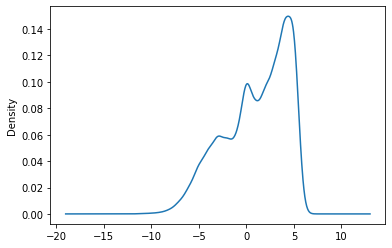

In [474]:
short_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_short']
med_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_medium']
deep_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_deep']
short_passes['air_yards'].plot.density()

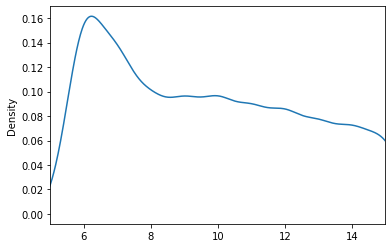

In [471]:
b = med_passes['air_yards'].plot.density(xlim=(5,15)).get_lines()[0].get_xydata()

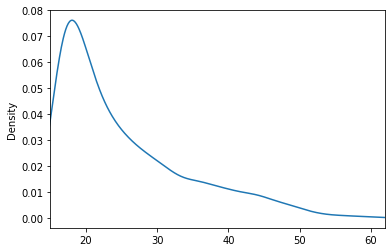

In [469]:
a = deep_passes['air_yards'].plot.density(xlim=(15,62)).get_lines()[0].get_xydata()

In [468]:
deep_passes['air_yards'].max()

60.0

In [480]:
catches = rec_plays.loc[(rec_plays['incomplete_pass']==0) & (rec_plays['interception']==0)]
catches['yards_after_catch'] = catches['yards_after_catch'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [484]:
catches['pos_team'] = catches['home_team']
catches.loc[catches['posteam_type']=='away','pos_team'] = catches['away_team']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [485]:
catches

,game_id,home_team,away_team,season_type,week,posteam_type,yardline_100,game_date,half_seconds_remaining,game_seconds_remaining,...,special_teams_play,spread_line,total_line,div_game,home_coach,away_coach,score_differential,out_of_bounds,pass_length_rec,pos_team
6,2020_01_ARI_SF,SF,ARI,REG,1,home,45.0,2020-09-13,1659.0,3459.0,...,0.0,7.0,48.5,1,Kyle Shanahan,Kliff Kingsbury,0.0,0.0,rec_medium,SF
9,2020_01_ARI_SF,SF,ARI,REG,1,away,75.0,2020-09-13,1610.0,3410.0,...,0.0,7.0,48.5,1,Kyle Shanahan,Kliff Kingsbury,-3.0,0.0,rec_short,ARI
10,2020_01_ARI_SF,SF,ARI,REG,1,away,72.0,2020-09-13,1584.0,3384.0,...,0.0,7.0,48.5,1,Kyle Shanahan,Kliff Kingsbury,-3.0,0.0,rec_medium,ARI
13,2020_01_ARI_SF,SF,ARI,REG,1,away,75.0,2020-09-13,1555.0,3355.0,...,0.0,7.0,48.5,1,Kyle Shanahan,Kliff Kingsbury,-3.0,0.0,rec_short,ARI
15,2020_01_ARI_SF,SF,ARI,REG,1,home,76.0,2020-09-13,1505.0,3305.0,...,0.0,7.0,48.5,1,Kyle Shanahan,Kliff Kingsbury,3.0,0.0,rec_short,SF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48501,2020_21_KC_TB,TB,KC,POST,21,away,50.0,2021-02-07,185.0,185.0,...,0.0,-3.0,55.0,0,Bruce Arians,Andy Reid,-22.0,0.0,rec_short,KC
48503,2020_21_KC_TB,TB,KC,POST,21,away,42.0,2021-02-07,157.0,157.0,...,0.0,-3.0,55.0,0,Bruce Arians,Andy Reid,-22.0,0.0,rec_deep,KC
48505,2020_21_KC_TB,TB,KC,POST,21,away,26.0,2021-02-07,132.0,132.0,...,0.0,-3.0,55.0,0,Bruce Arians,Andy Reid,-22.0,1.0,rec_short,KC
48506,2020_21_KC_TB,TB,KC,POST,21,away,25.0,2021-02-07,127.0,127.0,...,0.0,-3.0,55.0,0,Bruce Arians,Andy Reid,-22.0,0.0,rec_medium,KC


#Complete Model